# Train and evaluate on MNIST

In [1]:
import sys
sys.path.append('models')

In [2]:
import models.ExampleModels as em
import torch
import matplotlib.pyplot as plt 
import numpy as np

# Get Data

In [3]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torchsummary import summary

In [4]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [5]:
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

#train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
#valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Train Model

In [20]:
max_embed_size=40
min_p = .1
ae = em.AutoEncoder(max_embed_size,use_sq_dr= True,dr_min_p= min_p, scale_output=False)


Selected device: cpu


In [21]:
def plot_ae_outputs(ae,n=10):
    plt.figure(figsize=(16,4.5))
    encoder = ae.encoder
    decoder = ae.decoder
    device = ae.device
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   


 EPOCH 1/25 	 train loss 0.032248303294181824 	 val loss 0.019900541752576828


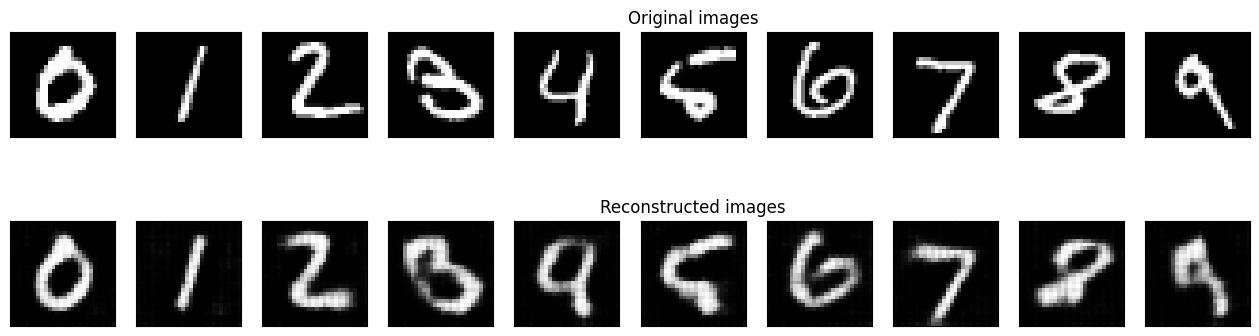

In [ ]:
num_epochs = 25
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(ae,n=10)

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# view ablation on an example

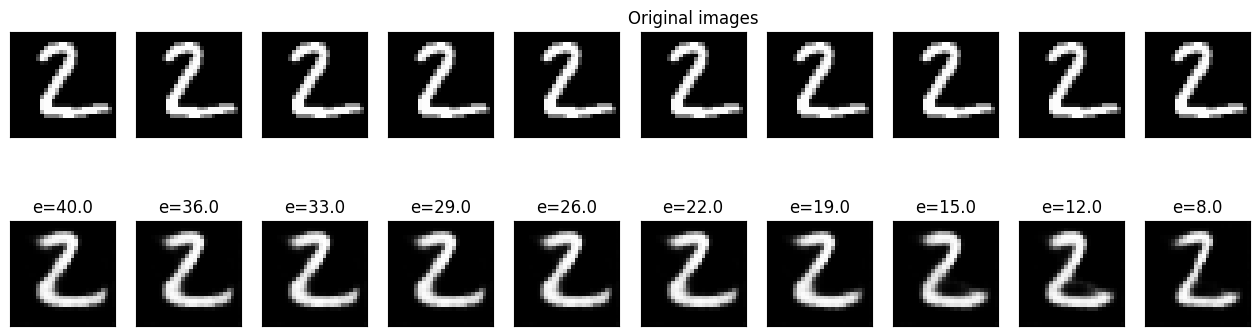

In [19]:
sample_idx = 1
n = 10
r = np.rint(np.linspace(max_embed_size,int(max_embed_size* min_p),n))
plt.figure(figsize=(16,4.5))
encoder = ae.encoder
decoder = ae.decoder
device = ae.device
for i, embed_size in enumerate(r):
    ax = plt.subplot(2,n,i+1)
    img = test_dataset[sample_idx][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # ablate embedding
        embedding = encoder(img)
        #create mask
       
        if embed_size < embedding.shape[1]:
            
            embedding[0][-int(embedding.shape[1] - embed_size) :] = 0 
            
        rec_img  = decoder(embedding)
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == n//2:
        ax.set_title('Original images')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    #if i == n//2:
    #    ax.set_title('Reconstructed images')
    ax.set_title(f"e={embed_size}")

In [ ]:
# Reconstruction metrics - also compare to reduced precision